In [2]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from tqdm.notebook import tqdm
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import time
from selenium.webdriver.common.by import By
import urllib
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
from user_agent import generate_user_agent
import json
import requests
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import numpy as np

In [3]:
def input_data(driver, class_O, input_date): #driver과 필터값을 주면 해당필터의 목록을 보여주고
                                #값을 받아 해당 카테고리로 이동하는 함수
    
    if class_O == "기간":
        xpath = """//*[@id="goodsRankForm"]/div[1]/div[1]/dl/dd/ul"""
    elif class_O == "대분류":
        xpath = """//*[@id="goodsRankForm"]/div[1]/div[2]/dl/dd/ul"""
    elif class_O == "중분류":
        xpath = """//*[@id="goodsRankForm"]/div[1]/div[3]/dl/dd/ul"""
    elif class_O == "가격":
        xpath = """//*[@id="goodsRankForm"]/div[1]/div[4]/dl/dd/ul"""
    else:
        print("잘못된 input_data함수 사용")
        return 0
    
    data_bar = driver.find_element(By.XPATH, xpath)
    data_list = data_bar.find_elements(By.TAG_NAME,"li")


    word = []

    for date in data_list:
        data_a_list = date.find_elements(By.TAG_NAME,"a")
        for data_a in data_a_list:
            word.append(data_a.get_attribute("innerText"))


    
    try:
        if input_date in word:
            num = word.index(input_date)
            a = data_list[num].find_elements(By.TAG_NAME,"a")
            if len(a) >= 2:
                a[1].click()
            else:
                a[0].click()
            #data_list[word.index(input_date)].click()
            
        else:
            raise TypeError 
    except TypeError:
        print("입력가능한 항목이 아닙니다.")
    


def get_more_info(product_numbers):
    import requests
    product_sellCount = []
    c=0
    # 사용자 정의 User-Agent
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    for goods_code in product_numbers:
        # URL을 동적으로 생성
        url = f'https://www.musinsa.com/app/product/goodsview_stats/{goods_code}/0?loc=goods_rank&menu=view'

        try:
            response = requests.get(url, headers=headers)
            response.raise_for_status()  # HTTP 요청이 성공적인지 확인

            text_data = response.text  # 응답 텍스트 가져오기

            # 'total' 다음에 나오는 값이 ','까지의 숫자로 이루어져 있다고 가정
            total_index = text_data.index('total')
            comma_index = text_data.index(',', total_index)

            total_value = text_data[total_index + len('total'):comma_index+2]
            product_sellCount.append(total_value)
            #print(f"{product_names[c]}:의 총 판매수는: {total_value}")
            c+=1
        except requests.exceptions.RequestException as e:
            print(f"Error during request for goods code {goods_code}: {e}")
    return product_sellCount


def get_product_data(driver):
    product_link = []
    product_names = []
    product_brand = []
    product_gender = []
    product_saleRate = []
    product_goods = []
    product_review_count = []
    product_member_price = []
    product_nomal_price = []
    product_tags = []
    product_bigCategory = []
    product_smallCategory = []
    product_rate = []
    product_number=[]

    xpath = """//*[@id="goodsRankList"]"""
    data_bar = driver.find_element(By.XPATH, xpath)
    data_list = data_bar.find_elements(By.CLASS_NAME,"list_img")


    goods_tmp = driver.find_element(By.ID,"goodsRankList")
    goods_like = goods_tmp.find_elements(By.NAME,"count")

    for like in goods_like:
        product_goods.append(like.get_attribute("innerText"))

    for data in data_list:
        link = (data.find_element(By.TAG_NAME,"a").get_attribute("href"))
        product_link.append(link)
        re = Request(url=link, headers={"User-Agent":generate_user_agent()})
        page = urlopen(re)
        soup = BeautifulSoup(page, "html.parser")
        product_names.append(soup.find(id="notexist_title").string)
        
        script_org = soup.find_all("script")
        script = script_org[-1].get_text()#
        script_low = (script[script.find("product.state = {")+len("product.state = {")-1:script.rfind(";")+1])
        val = eval(script_low[:script_low.rfind("}")+1].replace("false","False").replace("null","None").replace("true","True"))
        try:
            product_saleRate.append(val["differenceColorGoods"][0]["saleRate"])
        except IndexError:
            product_saleRate.append(0)

        product_number.append(val["goodsNo"])
        product_rate.append(data_list.index(data))
        product_brand.append(val["brand"])
        product_gender.append(val["sex"])
        product_bigCategory.append(val["category"]["categoryDepth1Title"])
        product_smallCategory.append(val["category"]["categoryDepth2Title"])
        product_review_count.append(val["goodsReview"]["totalCount"])
        product_member_price.append(val["goodsPriceMemberLevels"][0]["price"])
        product_nomal_price.append(val["goodsPrice"]["originPrice"])
        product_tags.append(str(val["goodsTags"]))
    

    product_sellCount = get_more_info(product_number)
    df = pd.DataFrame()
    df["링크"] = product_link
    df["이름"] = product_names
    df["브랜드"] = product_brand
    df["성별"] = product_gender
    df["할인율"] = product_saleRate
    df["대분류"] = product_bigCategory
    df["중분류"] = product_smallCategory
    df["좋아요수"] = product_goods
    df["리뷰개수"] = product_review_count
    df["회원가"] = product_member_price
    df["일반가"] = product_nomal_price
    df["태그"] = product_tags
    df["상품번호"] = product_number
    df["누적 구매수"] = product_sellCount
    return df




In [ ]:
options = webdriver.ChromeOptions()
prefs = {"download.default_directory":"/home/rds/amr_ws/edm/data",
        "download.prompt_for_download":False}
options.add_experimental_option("prefs",prefs)
url = "https://www.musinsa.com/ranking/best?period=now&age=ALL&mainCategory=&subCategory=&leafCategory=&price=&golf=false&kids=false&newProduct=false&exclusive=false&discount=false&soldOut=false&page=1&viewType=small&priceMin=&priceMax="
driver = webdriver.Chrome(service=Service("../../driver/chromedriver-linux64/chromedriver"),
                        options=options)
driver.get(url)
driver.maximize_window()
#대기



In [ ]:
data_frame = pd.DataFrame()
big_xpath = """//*[@id="goodsRankForm"]/div[1]/div[2]/dl/dd/ul"""
mid_xpath = """//*[@id="goodsRankForm"]/div[1]/div[3]/dl/dd/ul"""

data_bar = driver.find_element(By.XPATH, big_xpath)
big_list = data_bar.find_elements(By.TAG_NAME,"a")
big_texts = ["가방"] # 검색 대분류 목록
mid_black_list = ["환절기 코트","겨울 기타 코트", "패딩 베스트", "사파리/헌팅 재킷", "기타 아우터", "레깅스", "힐/펌프스", "플랫 슈즈", "신발 용품"]
# 중분류 블랙리스트


for big_text in big_texts:
    WebDriverWait(driver,10)
    input_data(driver,"대분류",big_text)
    WebDriverWait(driver,10)
    data_bar_mid = driver.find_element(By.XPATH, mid_xpath)
    mid_list = data_bar_mid.find_elements(By.TAG_NAME,"a")
    mid_texts = []
    
    for mid in mid_list:
        if mid.get_attribute("innerText") in mid_black_list:
            continue
        else:
            mid_texts.append(mid.get_attribute("innerText"))

    for mid_text in mid_texts:
        WebDriverWait(driver,10)
        input_data(driver,"중분류",mid_text)
        WebDriverWait(driver,10)
        data_frame = pd.concat([data_frame, get_product_data(driver)], axis=0)
        input_data(driver,"중분류",mid_text)
    input_data(driver,"대분류",big_text)
        






In [5]:
data_frame

NameError: name 'data_frame' is not defined

In [ ]:
big_text

In [ ]:
data_frame

In [5]:
df.to_csv("../../data/통합.csv")

In [ ]:
driver.close()

In [3]:

#################################################
# 주의 데이터 베이스로 df올리는 블럭임##################
#################################################
import mysql.connector
import pandas as pd
conn = mysql.connector.connect(
    host="database-1.cd2is2gsweff.ap-northeast-2.rds.amazonaws.com",
    port=3306,
    user="admin",
    password="kim82458529",
    database="amr_base"
)
cursor = conn.cursor(buffered=True)
cursor.execute("SELECT * FROM yousinsa")
columns = [i[0] for i in cursor.description]
df = pd.DataFrame(cursor.fetchall(), columns=columns)
cursor.close()
conn.close()



In [4]:
df['sex'] = df['sex'].str.replace('[', '').str.replace(']', '').str.replace("'", '')

In [5]:
df.columns

Index(['ranking', 'link', 'name', 'brand', 'sex', 'sale', 'sort', 'sort1',
       'likes', 'review', 'price_member', 'price_nomember', 'tag', 'number',
       'sold', 'age', 'like_sex'],
      dtype='object')

In [87]:
print(df_cleaned)

     ranking                                               link  \
836       26  https://www.musinsa.com/app/goods/3029727?loc=...   
838       28  https://www.musinsa.com/app/goods/3022409?loc=...   
853       43  https://www.musinsa.com/app/goods/970813?loc=g...   
878       68  https://www.musinsa.com/app/goods/1602760?loc=...   
875       65  https://www.musinsa.com/app/goods/1548158?loc=...   
..       ...                                                ...   
117       27  https://www.musinsa.com/app/goods/3048201?loc=...   
116       26  https://www.musinsa.com/app/goods/1737580?loc=...   
102       12  https://www.musinsa.com/app/goods/2106705?loc=...   
99         9  https://www.musinsa.com/app/goods/3463298?loc=...   
114       24  https://www.musinsa.com/app/goods/2913659?loc=...   

                                          name            brand     sex  sale  \
836                     (올시즌)ASI 하프 집업 맨투맨_오트밀     dimitriblack  남성, 여성    35   
838             REVERSE WEAVE PK 

In [100]:

# '상의' 카테고리만 선택
df_tops = df[df['sort'] == '상의']

# sold 대비 likes 비율 계산
df_tops['like_ratio'] = df_tops['likes'] / df_tops['sold']
# 출력
print(df_tops)

     ranking                                               link  \
836       26  https://www.musinsa.com/app/goods/3029727?loc=...   
838       28  https://www.musinsa.com/app/goods/3022409?loc=...   
853       43  https://www.musinsa.com/app/goods/970813?loc=g...   
878       68  https://www.musinsa.com/app/goods/1602760?loc=...   
875       65  https://www.musinsa.com/app/goods/1548158?loc=...   
..       ...                                                ...   
117       27  https://www.musinsa.com/app/goods/3048201?loc=...   
116       26  https://www.musinsa.com/app/goods/1737580?loc=...   
102       12  https://www.musinsa.com/app/goods/2106705?loc=...   
99         9  https://www.musinsa.com/app/goods/3463298?loc=...   
114       24  https://www.musinsa.com/app/goods/2913659?loc=...   

                                          name            brand     sex  sale  \
836                     (올시즌)ASI 하프 집업 맨투맨_오트밀     dimitriblack  남성, 여성    35   
838             REVERSE WEAVE PK 

/tmp/ipykernel_4349/1219786281.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tops['like_ratio'] = df_tops['likes'] / df_tops['sold']


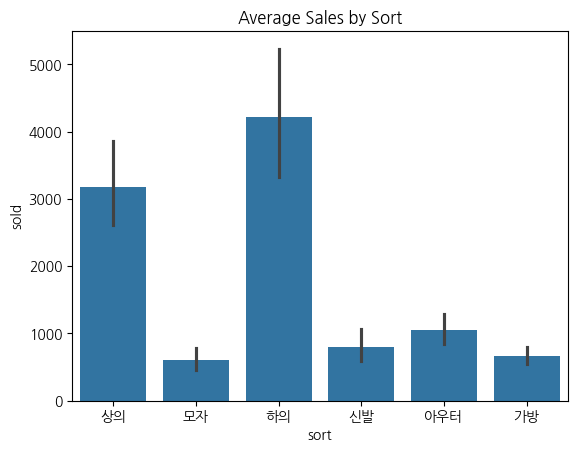

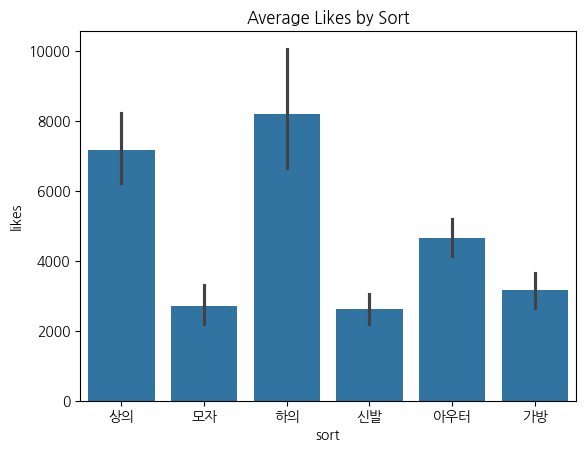

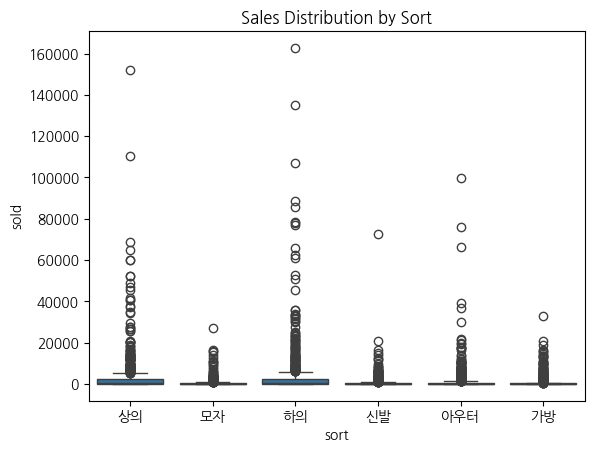

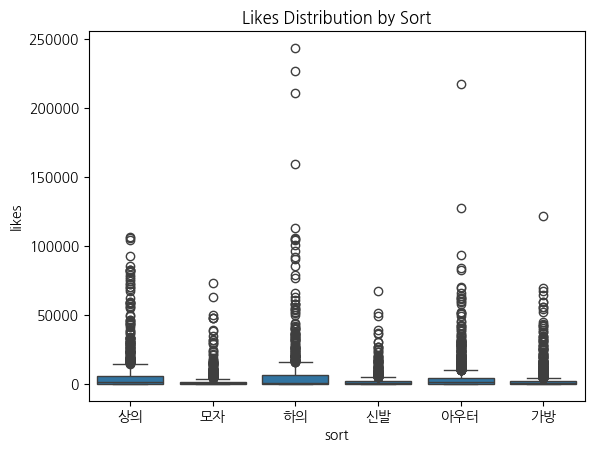

In [128]:
sns.barplot(x='sort', y='sold', data=df)
plt.title('Average Sales by Sort')
plt.show()

sns.barplot(x='sort', y='likes', data=df)
plt.title('Average Likes by Sort')
plt.show()

# 또는 boxplot을 사용하여 분포를 표현할 수 있습니다.
sns.boxplot(x='sort', y='sold', data=df)
plt.title('Sales Distribution by Sort')
plt.show()

sns.boxplot(x='sort', y='likes', data=df)
plt.title('Likes Distribution by Sort')
plt.show()
df['sold_likes_ratio'] = df['sold'] / df['likes']

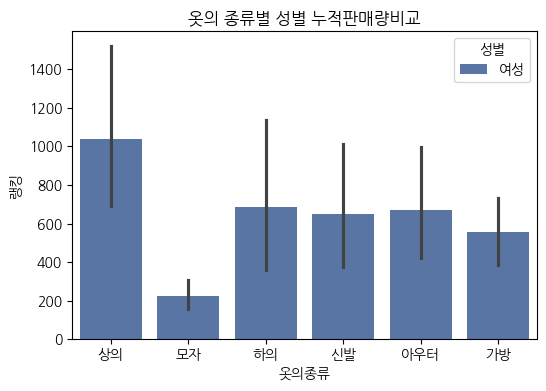

In [11]:
# 막대 그래프로 시각화
sns.set_theme(style="whitegrid")
plt.title('옷의 종류별 성별 누적판매량비교')
plt.xlabel('옷의종류')
plt.ylabel('랭킹')

# 범례 표시
plt.legend(title='성별')

# 그래프 보여주기
plt.show()

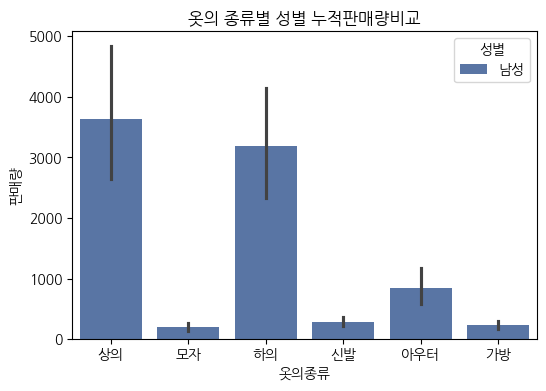

In [13]:
# 막대 그래프로 시각화
plt.figure(figsize=(6, 4))
df_cleaned = df[df['sex'] == '남성']
sns.barplot(x='sort', y='sold', hue='sex', data=df_cleaned, palette='deep')

# 그래프 제목과 축 레이블 설정
plt.title('옷의 종류별 성별 누적판매량비교')
plt.xlabel('옷의종류')
plt.ylabel('판매량')

# 범례 표시
plt.legend(title='성별')

# 그래프 보여주기
plt.show()

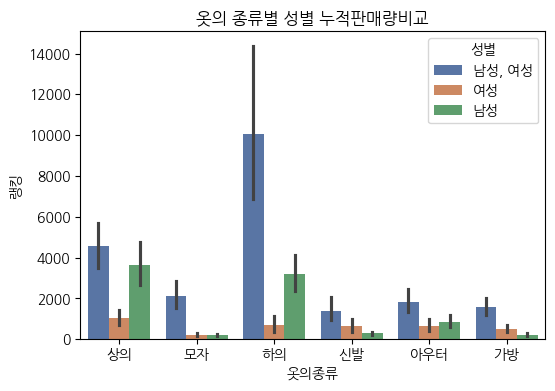

In [56]:

# 막대 그래프로 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x='sort', y='sold', hue='sex', data=df, palette='deep')

# 그래프 제목과 축 레이블 설정
plt.title('옷의 종류별 성별 누적판매량비교')
plt.xlabel('옷의종류')
plt.ylabel('랭킹')

     15 plt.ylabel('판매량')
     17 # x축 눈금 및 레이블 설정
---> 18 ax.set_xticks([j + 1.5 * bar_width for j in range(len(top_subcategories['sort1']))])
     19 ax.set_xticklabels(top_subcategories['sort1'])
...
   3801     #  InvalidIndexError. Otherwise we fall through and re-raise
   3802     #  the TypeError.
# 범례 표시
plt.legend(title='성별')

# 그래프 보여주기
plt.show()

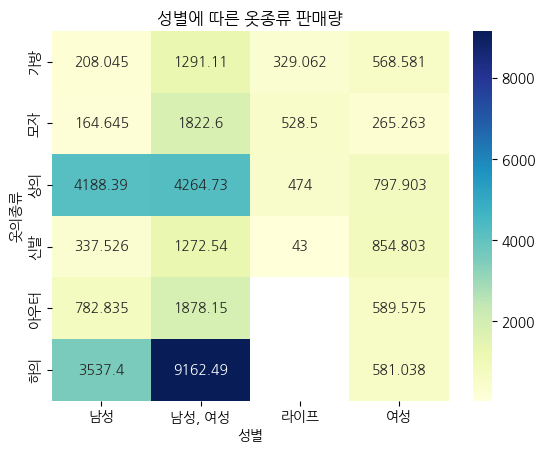

In [11]:

heatmap_data = pd.crosstab(index=df['sort'], columns=df['sex'], values=df['sold'], aggfunc='mean')
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt="g")

# 히트맵 설정
plt.title('성별에 따른 옷종류 판매량')
plt.xlabel('성별')
plt.ylabel('옷의종류')

# 히트맵 보여주기
plt.show()

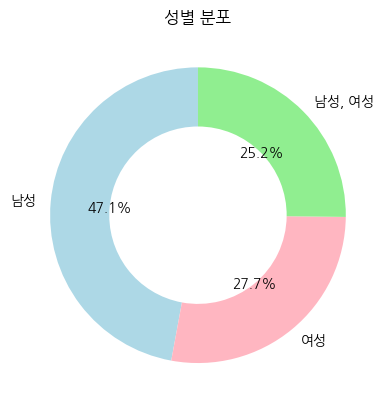

In [65]:

gender_counts = df['sex'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90,
        colors=['lightblue', 'lightpink','lightgreen'], wedgeprops=dict(width=0.4))
plt.title('성별 분포')
plt.show()

In [21]:
df.columns

Index(['ranking', 'link', 'name', 'brand', 'sex', 'sale', 'sort', 'sort1',
       'likes', 'review', 'price_member', 'price_nomember', 'tag', 'number',
       'sold', 'age', 'test_col', 'like_sex', 'age_numeric'],
      dtype='object')

### 상의 좋아요수

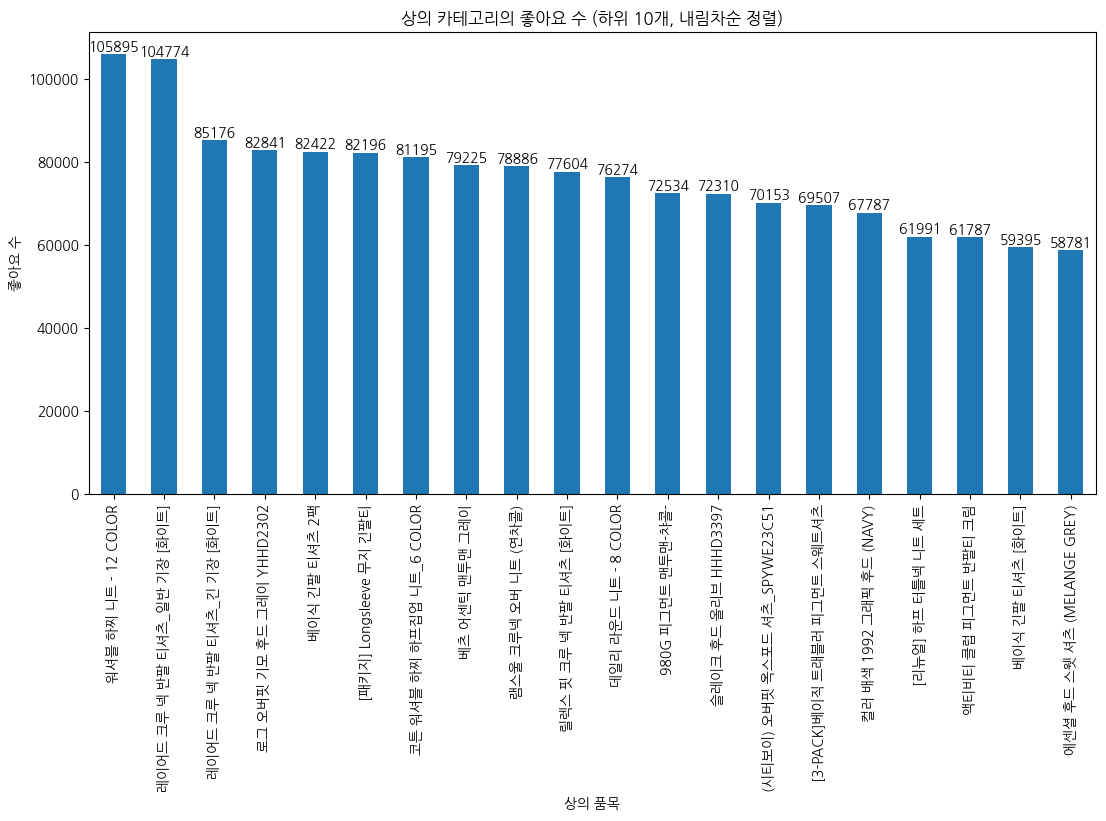

In [15]:
df_subset = df[df['sort'] == '상의']

# 좋아요 수를 기준으로 내림차순 정렬
df_sorted = df_subset.sort_values(by='likes', ascending=False).head(20)

# 'brand' 열을 x 값으로 사용하여 그래프 그리기
fig, ax = plt.subplots(figsize=(13, 6))
bar_plot = df_sorted.plot(kind='bar', x='name', y='likes', ax=ax, legend=False)

# 각 막대 위에 숫자 표시
for p in bar_plot.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# 그래프 꾸미기
ax.set_title('상의 카테고리의 좋아요 수 (하위 10개, 내림차순 정렬)')
ax.set_xlabel('상의 품목')
ax.set_ylabel('좋아요 수')

# 그래프 표시
plt.show()

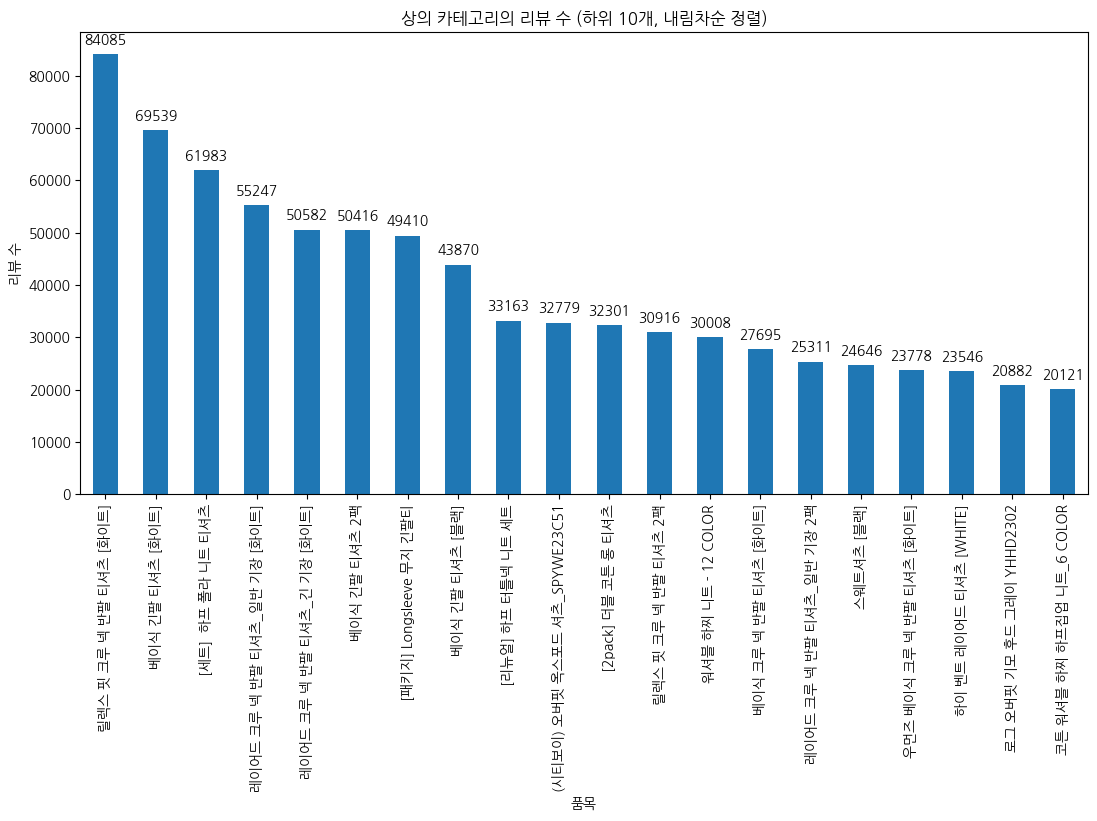

In [16]:
df_subset = df[df['sort'] == '상의']

# 좋아요 수를 기준으로 내림차순 정렬
df_sorted = df_subset.sort_values(by='review', ascending=False).head(20)

# 'brand' 열을 x 값으로 사용하여 그래프 그리기
fig, ax = plt.subplots(figsize=(13, 6))
bar_plot = df_sorted.plot(kind='bar', x='name', y='review', ax=ax, legend=False)

# 각 막대 위에 숫자 표시
for p in bar_plot.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 그래프 꾸미기
ax.set_title('상의 카테고리의 리뷰 수 (하위 10개, 내림차순 정렬)')
ax.set_xlabel('품목')
ax.set_ylabel('리뷰 수')

# 그래프 표시
plt.show()

In [4]:
df_subset = df[df['sort'] == '상의']

# 좋아요 수를 기준으로 내림차순 정렬
df_sorted = df_subset.sort_values(by='sold', ascending=False).head(20)

# 'brand' 열을 x 값으로 사용하여 그래프 그리기
fig, ax = plt.subplots(figsize=(13, 6))
bar_plot = df_sorted.plot(kind='bar', x='name', y='sold', ax=ax, legend=False)

# 각 막대 위에 숫자 표시
for p in bar_plot.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 그래프 꾸미기
ax.set_title('상의 카테고리의 판매수 (상위 10개, 내림차순 정렬)')
ax.set_xlabel('품목')
ax.set_ylabel('판매 수')

# 그래프 표시
plt.show()

,ranking,link,name,brand,sex,sale,sort,sort1,likes,review,price_member,price_nomember,tag,number,sold,age,like_sex
3330,0,https://www.musinsa.com/app/goods/2723767?loc=...,데일리 라운드 니트 - 8 COLOR,suare,"['남성', '여성']",0,상의,"니트,스웨터",76274,15427,36955,59000,"니트, 스웨터, 긴팔니트, 긴팔티, 가디건, 티셔츠, 니트웨어",2723767,38258,"24~28, 남성",남성
3331,1,https://www.musinsa.com/app/goods/2775713?loc=...,워셔블 하프 집업 카라넥 하찌 니트 (PURE BLACK),trillion,"['남성', '여성']",40,상의,"니트,스웨터",53508,4652,29400,49000,"스웨터, 집업니트, 모크넥, 오버핏, 카라니트, 가디건, 니트컬렉션, 젠더리스",2775713,20072,"19~23, 남성",남성
3332,2,https://www.musinsa.com/app/goods/2396645?loc=...,워셔블 하찌 니트 - 12 COLOR,suare,"['남성', '여성']",0,상의,"니트,스웨터",105895,30008,37905,59000,"니트, 스웨터, 긴팔니트, 오버핏니트, 기본니트, 남자니트, 니트웨어",2396645,52028,"19~23, 남성",남성
3333,3,https://www.musinsa.com/app/goods/1558847?loc=...,[리뉴얼] 하프 터틀넥 니트 세트,suare,['남성'],0,상의,"니트,스웨터",61991,33163,28405,66000,"긴팔티, 니트, 모크넥, 목폴라, 긴팔티셔츠, 오버핏, 터틀넥",1558847,37276,"24~28, 남성",남성
3334,4,https://www.musinsa.com/app/goods/3603134?loc=...,스트라이프 멀티 니트 (2color),anolorcode,['남성'],0,상의,"니트,스웨터",5698,245,40000,80000,"라운드니트, 긴팔니트, 겨울니트, 니트웨어, 23FW, 남자니트, 단가라니트",3603134,1496,"19~23, 남성",남성
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4225,85,https://www.musinsa.com/app/goods/1981956?loc=...,여성 요가복 DEVI-TS0032-화이트 필라테스 브라탑,deviwear,['여성'],0,상의,브라탑,2031,149,25781,29000,no data,1981956,150,"24~28, 여성",여성
4226,86,https://www.musinsa.com/app/goods/1983800?loc=...,B-에어로쉬 이너 반팔티셔츠 3매,byc,['남성'],0,상의,언더레이어,269,159,19900,39900,"반팔티셔츠, 남성, 반팔티, 여름반팔티, 티셔츠, 반팔, 스포츠",1983800,258,"24~28, 남성",남성
4227,87,https://www.musinsa.com/app/goods/2017604?loc=...,일반 사계절용 언더레이어 반팔라운드넥,gearx,['남성'],0,상의,언더레이어,135,76,14736,14900,"기능성언더레이어, 스포츠언더레이어, 기능성이너웨어, 등산내의, 골프내의, 운동내의,...",2017604,96,"24~28, 남성",남성
4228,88,https://www.musinsa.com/app/goods/2020969?loc=...,에어라이트 스포츠 브라탑,conchwear,['여성'],0,상의,브라탑,2449,550,29571,29900,"애슬레저, 필라테스복, 요가복, 운동복, 애슬레저룩, 피트니스, 홀리데이",2020969,799,"19~23, 여성",여성


In [12]:
df_subset = df[df['age'] != '0']

# 'age' 열의 고유값 다시 확인
unique_ages = sorted(df_subset['age'].unique())
print(unique_ages)
group_mapping = {'18,  남성': 1, '18,  여성': 2, '19~23,  남성': 3, '19~23,  여성': 4, '24~28,  남성': 5, '24~28,  여성': 6,
                    '29~33,  남성':7,'29~33,  여성':8,'34~39,  남성':9,'34~39,  여성':10,'40,  남성':11,'40,  여성':12}
df_subset['age_numeric'] = df_subset['age'].map(group_mapping)
df_grouped = df_subset.groupby('age')['age_numeric'].sum().reset_index()

df_grouped

['18,  남성', '18,  여성', '19~23,  남성', '19~23,  여성', '24~28,  남성', '24~28,  여성', '29~33,  남성', '29~33,  여성', '34~39,  남성', '34~39,  여성', '40,  남성', '40,  여성']


/tmp/ipykernel_24871/2078121133.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['age_numeric'] = df_subset['age'].map(group_mapping)


,age,age_numeric
0,"18, 남성",25
1,"18, 여성",76
2,"19~23, 남성",1548
3,"19~23, 여성",1616
4,"24~28, 남성",5070
5,"24~28, 여성",4032
6,"29~33, 남성",3521
7,"29~33, 여성",936
8,"34~39, 남성",558
9,"34~39, 여성",150


In [21]:
df['age']

0       19~23,  남성
1                0
2       19~23,  여성
3          18,  여성
4       24~28,  여성
           ...    
5665             0
5666             0
5667             0
5668    19~23,  여성
5669    24~28,  남성
Name: age, Length: 5670, dtype: object

In [43]:
df_subset = df[df['age'] != '0']

# 'age' 열의 고유값 다시 확인
unique_ages = sorted(df_subset['age'].unique())
print(unique_ages)
group_mapping = {'18,  남성': 1, '18,  여성': 2, '19~23,  남성': 3, '19~23,  여성': 4, '24~28,  남성': 5, '24~28,  여성': 6,
                    '29~33,  남성':7,'29~33,  여성':8,'34~39,  남성':9,'34~39,  여성':10,'40,  남성':11,'40,  여성':12}
df_subset['age_numeric'] = df_subset['age'].map(group_mapping)
df_grouped = df_subset.groupby('brand')['age_numeric'].sum().reset_index()

# 선호집단 '18' 추출
group_18m = df_subset[df_subset['age'] == '18,  남성']
group_18w = df_subset[df_subset['age'] == '18,  여성']

# 선호집단 '19~23 ' 추출
group_19_23m = df_subset[df_subset['age'] == '19~23,  남성']
group_19_23w = df_subset[df_subset['age'] == '19~23,  여성']

# 선호집단 '24~28 ' 추출
group_24_28m = df_subset[df_subset['age'] == '24~28,  남성']
group_24_28w = df_subset[df_subset['age'] == '24~28,  여성']

# 선호집단 '29~33 ' 추출
group_29_33m = df_subset[df_subset['age'] == '29~33,  남성']
group_29_33w = df_subset[df_subset['age'] == '29~33,  여성']

# 선호집단 '34~39 ' 추출
group_34_39m = df_subset[df_subset['age'] == '34~39,  남성']
group_34_39w = df_subset[df_subset['age'] == '34~39,  여성']

# 선호집단 '40' 추출
group_40m = df_subset[df_subset['age'] == '40,  남성']

group_40w = df_subset[df_subset['age'] == '40,  여성']

print(group_18w)


['18,  남성', '18,  여성', '19~23,  남성', '19~23,  여성', '24~28,  남성', '24~28,  여성', '29~33,  남성', '29~33,  여성', '34~39,  남성', '34~39,  여성', '40,  남성', '40,  여성']
      ranking                                               link  \
3           3  https://www.musinsa.com/app/goods/2897038?loc=...   
33         33  https://www.musinsa.com/app/goods/3426543?loc=...   
37         37  https://www.musinsa.com/app/goods/2122587?loc=...   
52         52  https://www.musinsa.com/app/goods/2287430?loc=...   
68         68  https://www.musinsa.com/app/goods/3512114?loc=...   
76         76  https://www.musinsa.com/app/goods/2700858?loc=...   
743        23  https://www.musinsa.com/app/goods/2108160?loc=...   
758        38  https://www.musinsa.com/app/goods/2287954?loc=...   
784        64  https://www.musinsa.com/app/goods/1696735?loc=...   
810         0  https://www.musinsa.com/app/goods/3042935?loc=...   
827        17  https://www.musinsa.com/app/goods/719069?loc=g...   
828        18  https://www.

/tmp/ipykernel_12658/2404508582.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['age_numeric'] = df_subset['age'].map(group_mapping)


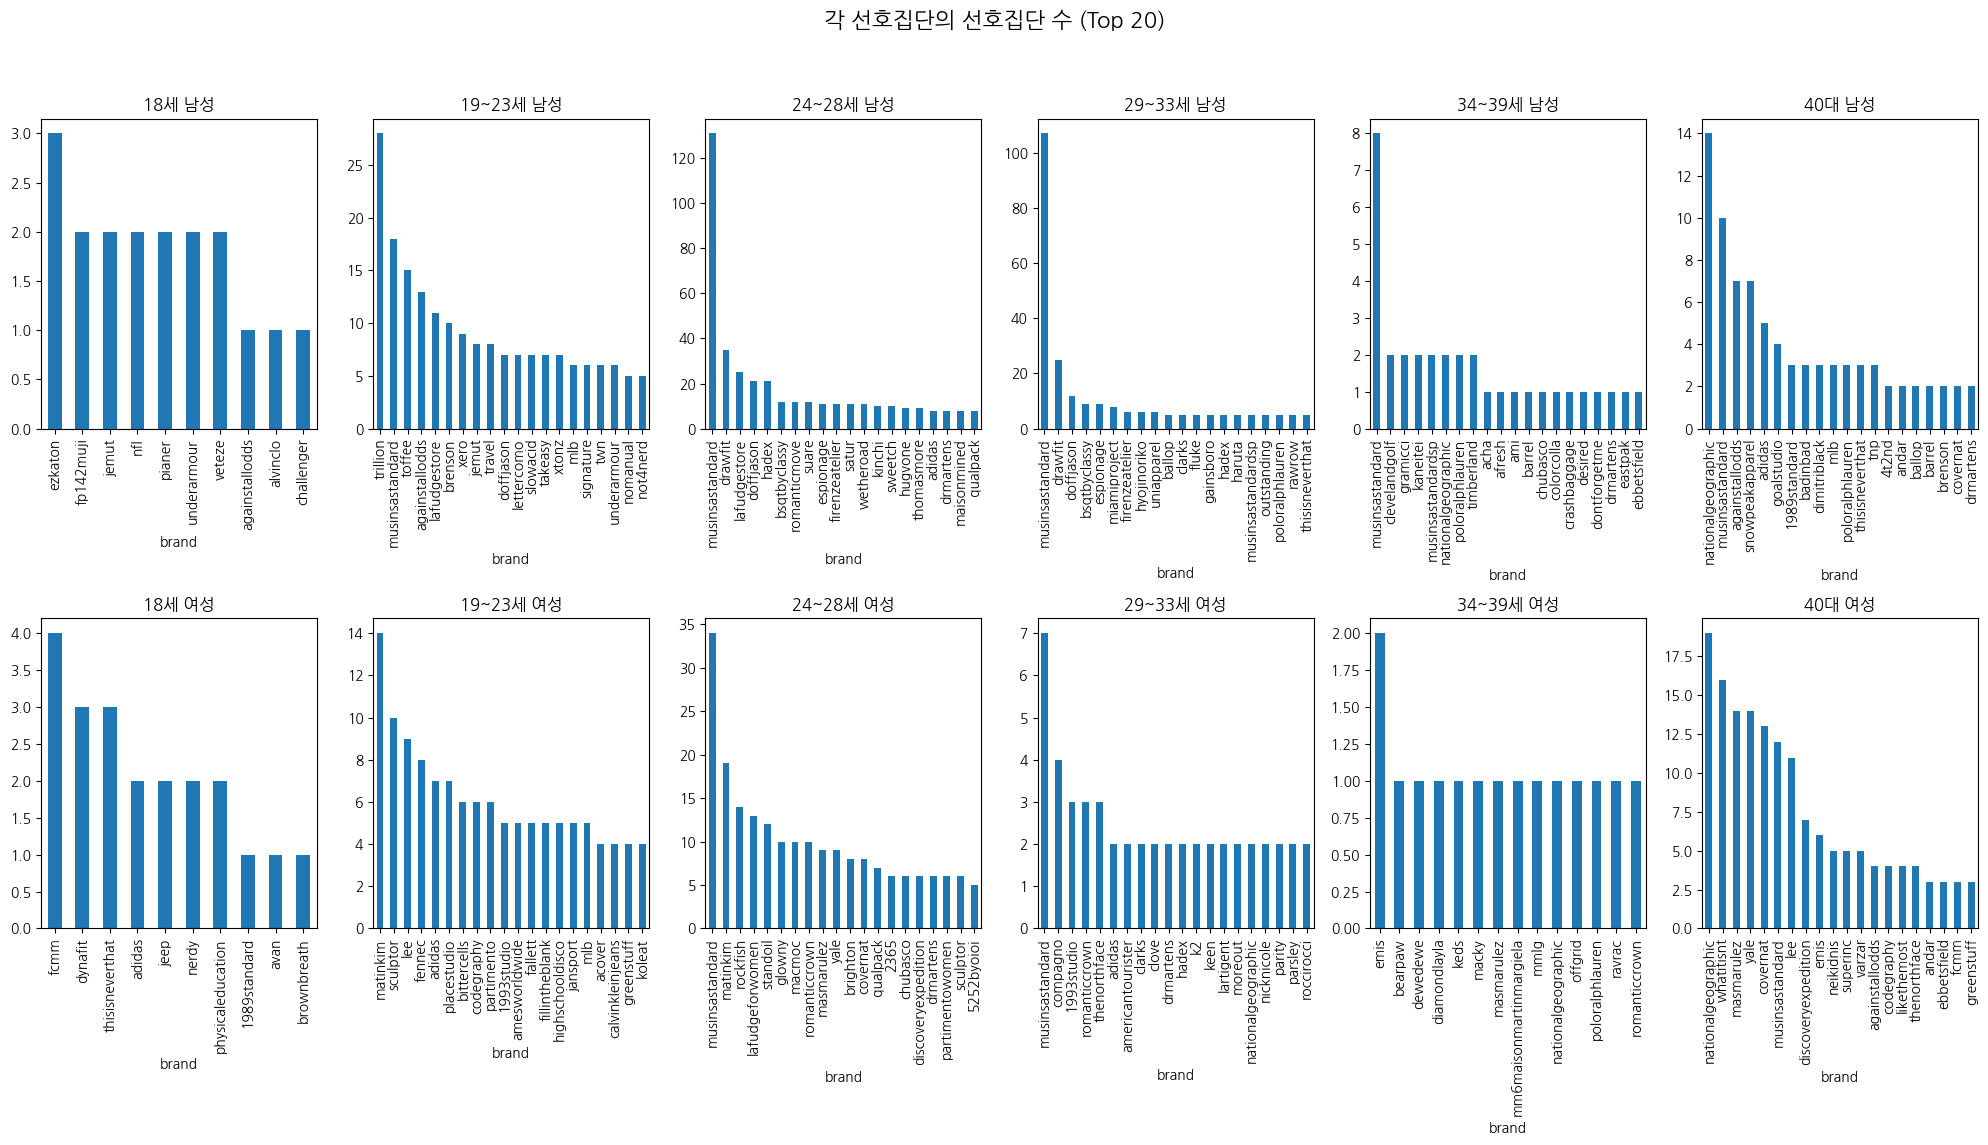

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# 주어진 데이터프레임 및 코드
# ...

# 선호 집단 '18'에 대한 상위 20개 그래프 추가
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20, 12))
fig.suptitle('각 선호집단의 선호집단 수 (Top 20)', fontsize=16)

bar_plot_18m = group_18m.groupby('brand')['age_numeric'].count().nlargest(10).plot(kind='bar', ax=axes[0, 0], legend=False)
axes[0, 0].set_title('18세 남성')
bar_plot_18w = group_18w.groupby('brand')['age_numeric'].count().nlargest(10).plot(kind='bar', ax=axes[1, 0], legend=False)
axes[1, 0].set_title('18세 여성')

bar_plot_19_23m = group_19_23m.groupby('brand')['age_numeric'].count().nlargest(20).plot(kind='bar', ax=axes[0, 1], legend=False)
axes[0, 1].set_title('19~23세 남성')
bar_plot_19_23w = group_19_23w.groupby('brand')['age_numeric'].count().nlargest(20).plot(kind='bar', ax=axes[1, 1], legend=False)
axes[1, 1].set_title('19~23세 여성')

bar_plot_24_28m = group_24_28m.groupby('brand')['age_numeric'].count().nlargest(20).plot(kind='bar', ax=axes[0, 2], legend=False)
axes[0, 2].set_title('24~28세 남성')
bar_plot_24_28w = group_24_28w.groupby('brand')['age_numeric'].count().nlargest(20).plot(kind='bar', ax=axes[1, 2], legend=False)
axes[1, 2].set_title('24~28세 여성')

bar_plot_29_33m = group_29_33m.groupby('brand')['age_numeric'].count().nlargest(20).plot(kind='bar', ax=axes[0, 3], legend=False)
axes[0, 3].set_title('29~33세 남성')
bar_plot_29_33w = group_29_33w.groupby('brand')['age_numeric'].count().nlargest(20).plot(kind='bar', ax=axes[1, 3], legend=False)
axes[1, 3].set_title('29~33세 여성')

bar_plot_34_39m = group_34_39m.groupby('brand')['age_numeric'].count().nlargest(20).plot(kind='bar', ax=axes[0, 4], legend=False)
axes[0, 4].set_title('34~39세 남성')
bar_plot_34_39w = group_34_39w.groupby('brand')['age_numeric'].count().nlargest(20).plot(kind='bar', ax=axes[1, 4], legend=False)
axes[1, 4].set_title('34~39세 여성')

bar_plot_40m = group_40m.groupby('brand')['age_numeric'].count().nlargest(20).plot(kind='bar', ax=axes[0, 5], legend=False)
axes[0, 5].set_title('40대 남성')
bar_plot_40w = group_40w.groupby('brand')['age_numeric'].count().nlargest(20).plot(kind='bar', ax=axes[1, 5], legend=False)
axes[1, 5].set_title('40대 여성')

# 그래프 간 간격 조절
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 모든 그래프 표시
plt.show()

/tmp/ipykernel_12658/1786933009.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['age_numeric'] = df_subset['age'].map(group_mapping)


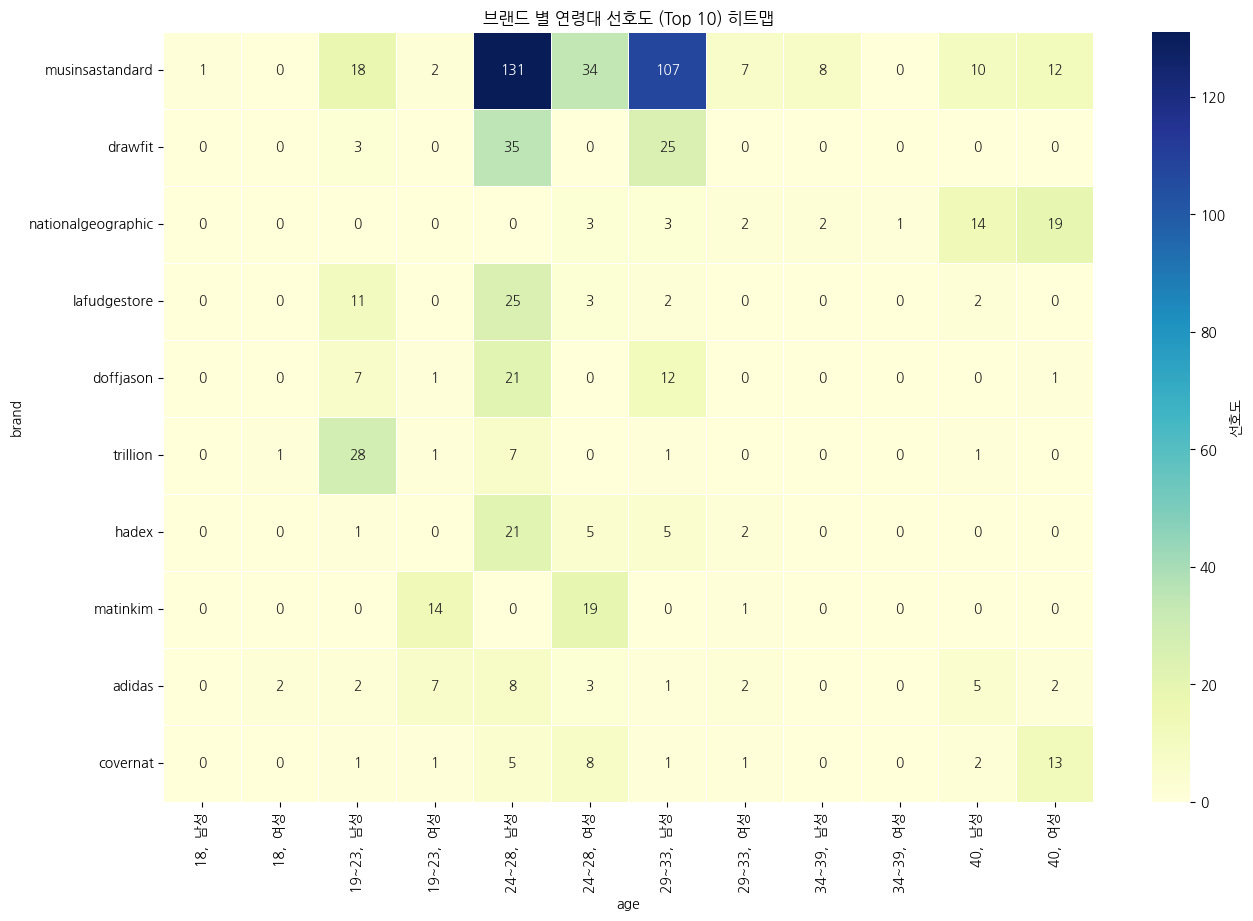

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 주어진 데이터프레임에서 'brand'와 'age_numeric' 열을 추출
df_subset = df[df['age'] != '0']
group_mapping = {'18,  남성': 1, '18,  여성': 2, '19~23,  남성': 3, '19~23,  여성': 4, '24~28,  남성': 5, '24~28,  여성': 6,
                    '29~33,  남성': 7, '29~33,  여성': 8, '34~39,  남성': 9, '34~39,  여성': 10, '40,  남성': 11, '40,  여성': 12}
df_subset['age_numeric'] = df_subset['age'].map(group_mapping)
df_grouped = df_subset.groupby(['brand', 'age'])['age_numeric'].count().unstack(fill_value=0)

# 상위 10개 브랜드 추출
top_10_brands = df_grouped.sum(axis=1).nlargest(10).index
df_top_10 = df_grouped.loc[top_10_brands]

# 히트맵 크기 조절
plt.figure(figsize=(15, 10))

# 히트맵 생성
sns.heatmap(df_top_10, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5, cbar_kws={'label': '선호도'})

# 히트맵 제목 설정
plt.title('브랜드 별 연령대 선호도 (Top 10) 히트맵')

# 히트맵 표시
plt.show()


In [6]:
group_18w_result = group_18w.groupby('brand')['age_numeric'].count().nlargest(10)
print(group_18w_result)


brand
fcmm                 4
dynafit              3
thisisneverthat      3
adidas               2
jeep                 2
nerdy                2
physicaleducation    2
1989standard         1
avan                 1
brownbreath          1
Name: age_numeric, dtype: int64


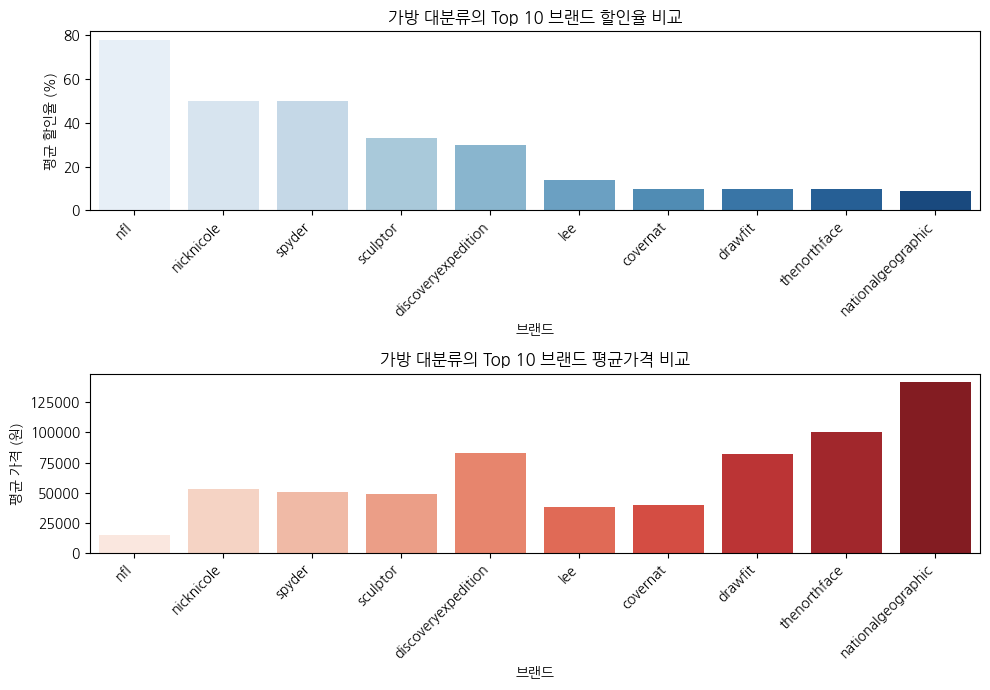

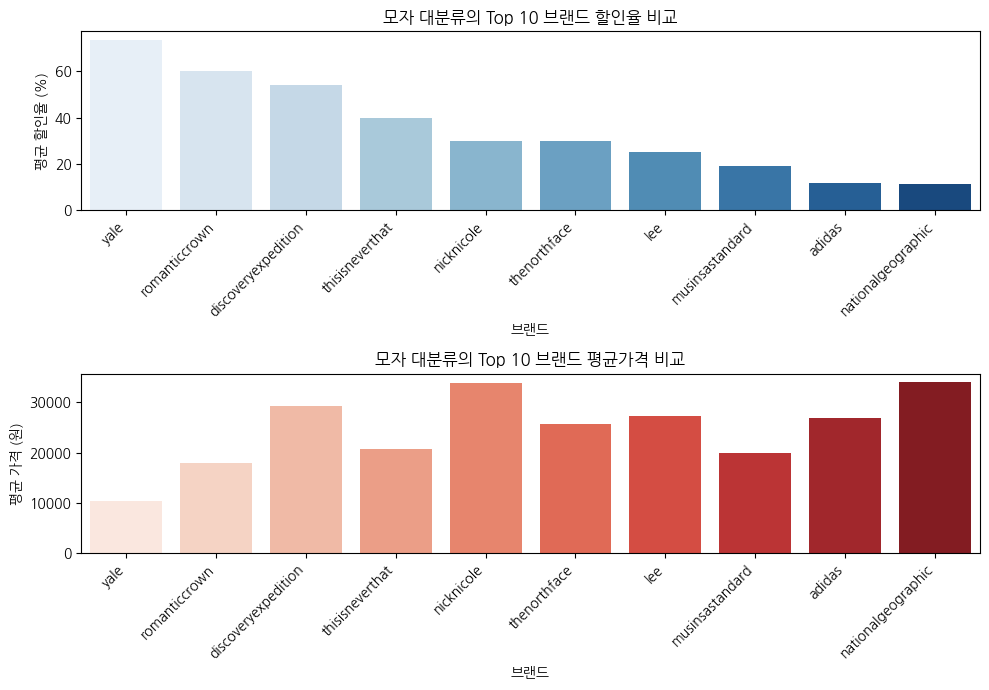

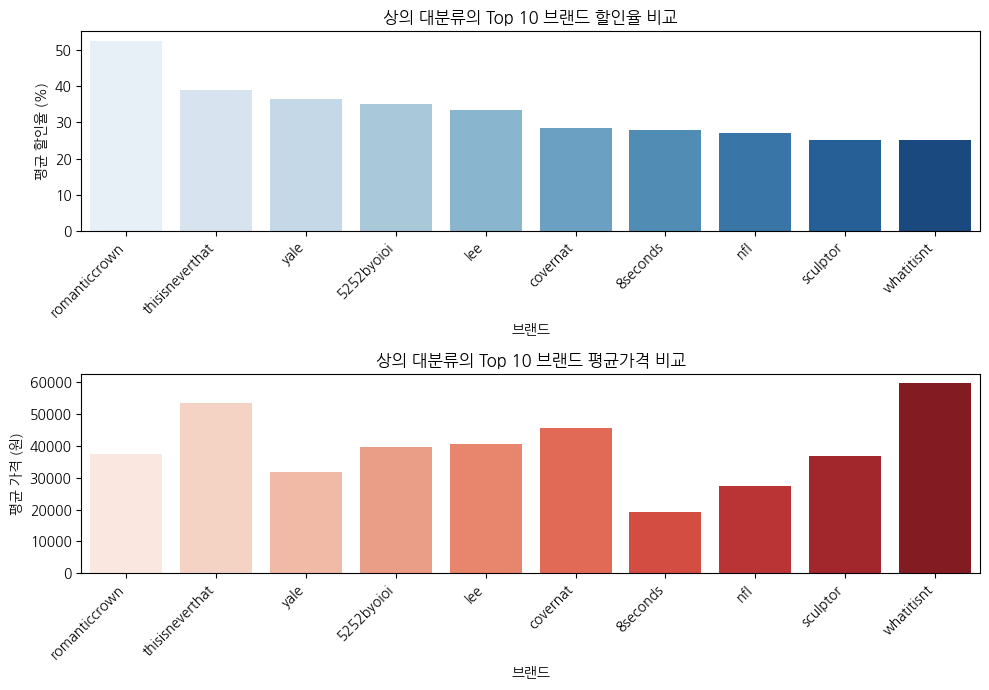

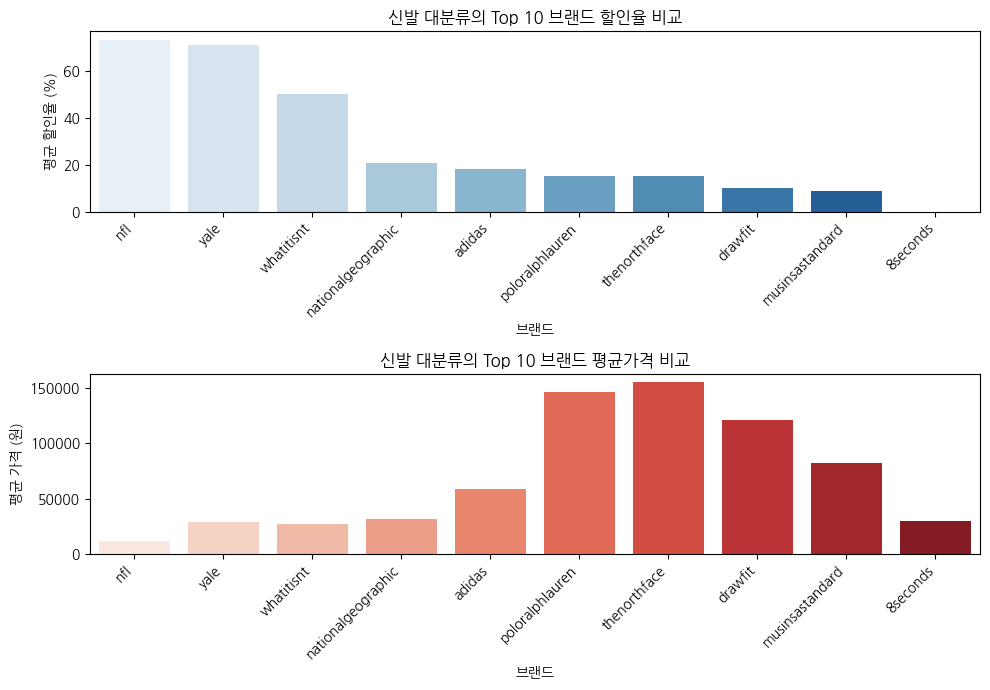

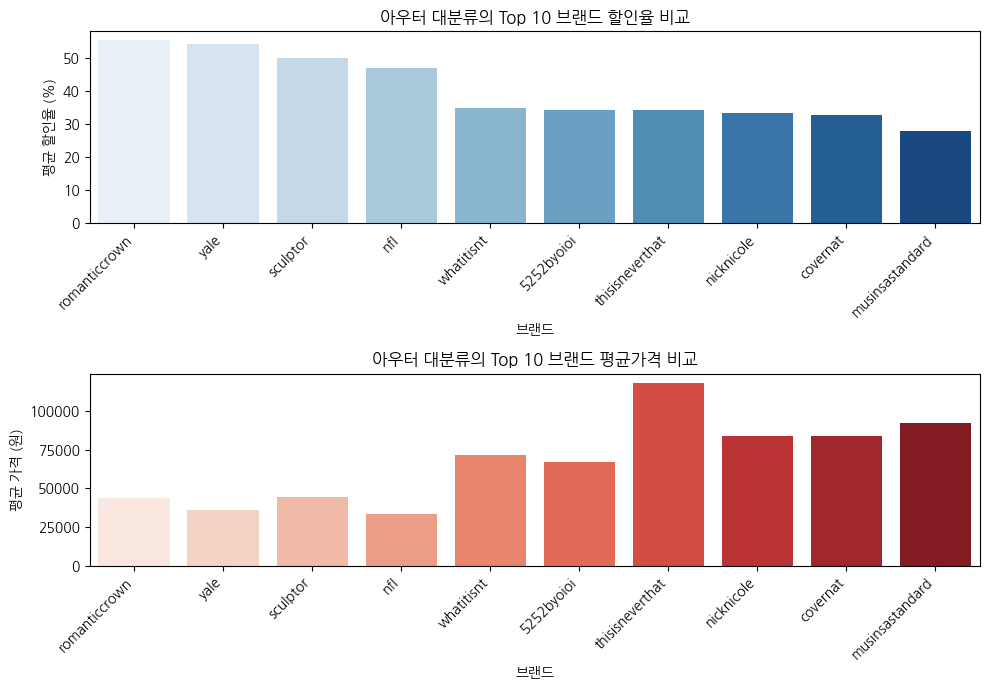

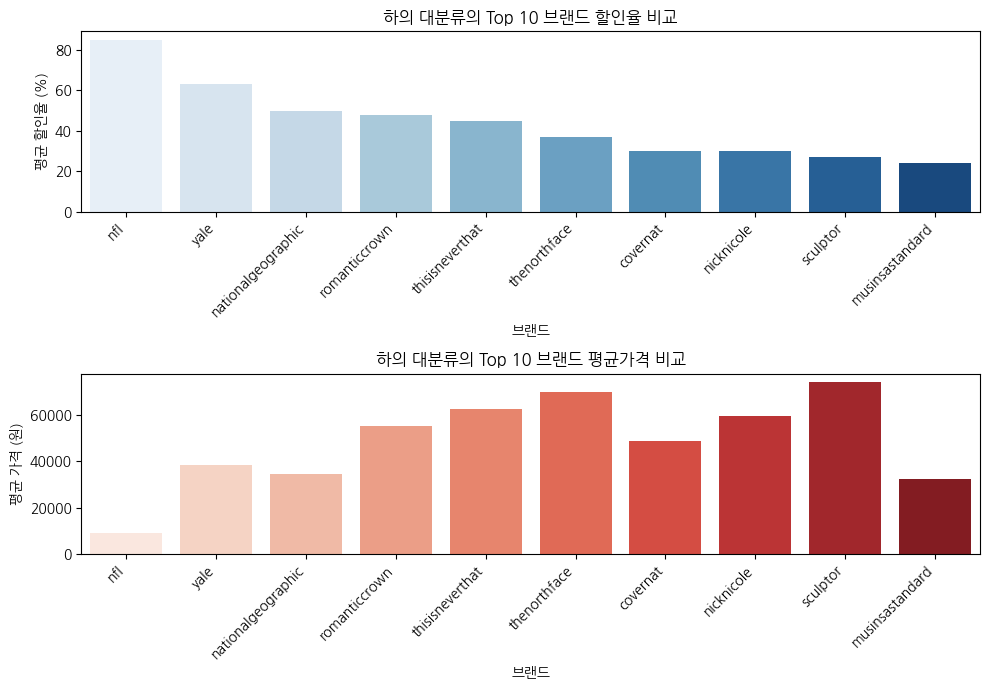

brand
yale                   6
nationalgeographic     6
musinsastandard        6
discoveryexpedition    6
umbro                  6
                      ..
anedit                 1
front2line             1
bsj                    1
peopleoftheworld       1
nuakle                 1
Name: count, Length: 1331, dtype: int64

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 필요한 라이브러리 및 데이터 로딩
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

top_brands_df = df.groupby(['sort', 'brand']).agg({'sale': 'mean', 'price_member': 'mean', 'price_nomember': 'mean'}).reset_index()
brand_counts = top_brands_df['brand'].value_counts()
brands_with_10_or_more = brand_counts[brand_counts >= 5].index
top_brands_df = top_brands_df[top_brands_df['brand'].isin(brands_with_10_or_more)]
top_brands_df = top_brands_df.sort_values(['sort', 'sale'], ascending=[True, False])

# Define a function to get the top 10 brands or all if less than 10
def get_top_brands(data):
    return data.head(10)

top_brands_df = top_brands_df.groupby('sort', group_keys=False).apply(get_top_brands)

# 6개의 차트를 그리기 위한 함수
def plot_analysis_charts(data, title):
    plt.figure(figsize=(10, 7))
    # 할인율 분석
    plt.subplot(2, 1, 1)
    sns.barplot(x='brand', y='sale', hue='brand', data=data, palette='Blues')
    plt.title(f'{title} 대분류의 Top 10 브랜드 할인율 비교')
    plt.xlabel('브랜드')
    plt.ylabel('평균 할인율 (%)')
    plt.xticks(rotation=45, ha='right')
    # 평균가격 비교
    plt.subplot(2, 1, 2)
    sns.barplot(x='brand', y='price_member', hue='brand', data=data, palette='Reds')
    plt.title(f'{title} 대분류의 Top 10 브랜드 평균가격 비교')
    plt.xlabel('브랜드')
    plt.ylabel('평균 가격 (원)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 대분류별로 차트 그리기
categories = top_brands_df['sort'].unique()
for category in categories:
    category_data = top_brands_df[top_brands_df['sort'] == category]
    plot_analysis_charts(category_data, category)
brand_counts

In [18]:
# 이상치 제거 예시
q_low = df['sale'].quantile(0.01)
q_high = df['sale'].quantile(0.99)
df_filtered = df[(df['sale'] > q_low) & (df['sale'] < q_high)]
df_filtered.tail(10)

,ranking,link,name,brand,sex,sale,sort,sort1,likes,review,price_member,price_nomember,tag,number,sold,age,like_sex,discount_rate
5625,45,https://www.musinsa.com/app/goods/3596631?loc=...,[WARM-UP] 코지 스웨이드 양털 투웨이 플랫폼 샌들 HPCV8D4V04,shoopen,여성,10,신발,부츠,11442,667,35550,39900,"어그부츠, 양털부츠, 퍼슈즈, 털부츠, 털신발, 어그슬리퍼, 레이디제인, 슈펜어그",3596631,3840,"19~23, 여성",여성,10.902256
5627,47,https://www.musinsa.com/app/goods/2829907?loc=...,하이탑 첼시 롱부츠 (BLACK),cesti,여성,25,신발,부츠,1198,11,125355,169000,"여성부츠, 기본롱부츠, 앵클부츠, 여성롱부츠, 롱부츠, 여자롱부츠, 하이탑부츠",2829907,49,"24~28, 여성",여성,25.825444
5632,52,https://www.musinsa.com/app/goods/2143833?loc=...,SECOND.A 스탠다드 라운드토 첼시부츠 2NDF2300GB [BLACK],firenzeatelier,남성,15,신발,부츠,16540,3009,84864,119000,"세컨드아뜨리에, 첼시",2143833,4508,"19~23, 남성",남성,28.685714
5634,54,https://www.musinsa.com/app/goods/2098793?loc=...,WTRD5205 제롬 스퀘어토 첼시부츠 블랙 [250~290MM],wetheroad,"남성, 여성",15,신발,부츠,11965,2055,77732,109000,"남자부츠, 부츠, 첼시부츠, 미니멀, 스퀘어토, 키높이신발, 키높이, 젠더리스",2098793,2407,"24~28, 남성",남성,28.686239
5641,61,https://www.musinsa.com/app/goods/3233309?loc=...,BSM RAIN BOOTS MID - HONEY BUTTER,bensimon,여성,10,신발,부츠,2820,172,79219,89000,"벤시몽레인부츠, 레인부츠, 여름부츠, 장화, 여성장화, 생일선물, 여자친구선물",3233309,696,"24~28, 여성",여성,10.989888
5645,65,https://www.musinsa.com/app/goods/1669101?loc=...,Tom 청키 첼시부츠 5cm,macmoc,여성,25,신발,부츠,5072,317,62295,99000,no data,1669101,365,"24~28, 여성",여성,37.075758
5646,66,https://www.musinsa.com/app/goods/3702084?loc=...,벌루니 2WAY 플랫폼 숏 부츠 FLOTDF4W11,otz,여성,10,신발,부츠,1795,67,56880,79900,퍼슈즈,3702084,380,"24~28, 여성",여성,28.811014
5656,76,https://www.musinsa.com/app/goods/3702080?loc=...,벌루니 플랫폼 패딩 부츠 FLOTDF4W19,otz,여성,39,신발,부츠,1314,23,38710,79900,no data,3702080,114,"24~28, 여성",여성,51.551940
5660,80,https://www.musinsa.com/app/goods/139458?loc=g...,슬림쉐입 미니멀 유광소가죽 앵클부츠 3333 [BLACK BOX],firenzeatelier,남성,10,신발,부츠,203,24,164020,205000,"앵글부츠, 피렌체, 블랙, 남자부츠, 앵클부츠, 부츠",139458,0,0,0,19.990244
5666,86,https://www.musinsa.com/app/goods/392776?loc=g...,4.7cm 카스타솔 미니멀 지퍼 앵클부츠 3335 [BLACK FG],firenzeatelier,남성,10,신발,부츠,176,15,164020,205000,"앵글부츠, 블랙, 가죽부츠, 수제화부츠, 지퍼부츠, 앵클부츠",392776,0,0,0,19.990244
